In [1]:
import copy

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader as GraphDataLoader
import numpy as np
import pandas as pd
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler

from src.early_stopping import EarlyStopping
from src.splitters import ScaffoldSplitter
from src.featurizers import GraphFeaturizer
from src.models.gnn import GraphConvolutionalNetwork
from src.dataset import (
    create_synthetic_dataset,
    create_synthetic_target,
    load_herg_data_split,
    load_cyp_data_split,
    load_synthetic_data_split,
)
from src.explanations import (
    grad_cam,
    saliency_map,
    batch_grad_cam,
    batch_saliency_map,
    plot_grad_cam_explanation,
    plot_saliency_map_explanation,
    rate_explanation_on_synthetic_data,
    get_n_atom_connected_components,
)
from src.metrics import (
    calculate_batch_explanation_contrastivity,
    calculate_batch_explanation_sparsity,
)
from src.utils import (
    get_data_partition_on_substructure_presence,
    get_sub_molecule,
    get_iupac_name_of_smiles
)
from tuning_results import (
    synthetic_gnn_params,
    herg_gnn_params,
    cyp_gnn_params,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\kamil\miniconda3\envs\masters\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
train, _, test = load_herg_data_split()

graph_featurizer = GraphFeaturizer("y", log_target_transform=False)
graph_train = graph_featurizer(train)
graph_test = graph_featurizer(test)

best_params = herg_gnn_params
dataset_name = "herg"
model = GraphConvolutionalNetwork(
    input_dim=graph_train[0].x.shape[1],
    hidden_size=best_params["hidden_size"],
    n_layers=best_params["num_layers"],
    dropout=best_params["dropout"]
).to(device)
model.load_state_dict(torch.load(f"models/gnn_tuned_{dataset_name}.pth"))

Found local copy...
Loading...
Done!
[18:23:18] WARNING: not removing hydrogen atom without neighbors
[18:23:18] WARNING: not removing hydrogen atom without neighbors


<All keys matched successfully>

### Find all connected components of size N in a molecule among atoms highlighted by an explanation method

This will serve as an input to the LLM when asking about the effect of having a certain component in the molecule on an ADMET property.

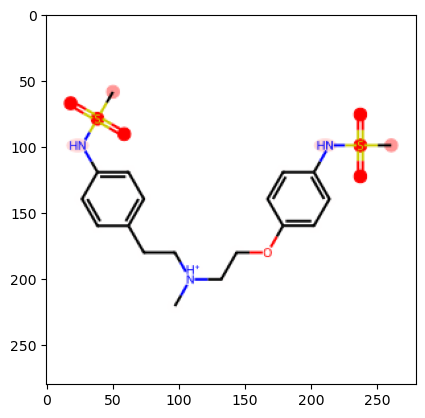

In [3]:
mol_index = 7
grad_cam_score = grad_cam(model, graph_train[mol_index])
plot_grad_cam_explanation(model, train[mol_index], graph_train[mol_index])

In [4]:
n_atom_connected_components = get_n_atom_connected_components(train[mol_index], grad_cam_score, 0.01, 3)

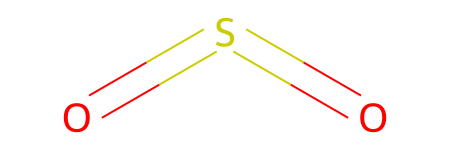

In [5]:
get_sub_molecule(train[mol_index], n_atom_connected_components[0])

In [6]:
components = []
for i in range(100):
    exp_scores = grad_cam(model, graph_train[i])
    scaled_exp_scores = MinMaxScaler().fit_transform(exp_scores.reshape(-1, 1)).reshape(-1)
    connected_components = get_n_atom_connected_components(train[i], scaled_exp_scores, 0.1, 3)
    connected_components_mols = [get_sub_molecule(train[i], component) for component in connected_components]
    components.extend(connected_components_mols)
components_smiles = list(map(Chem.MolToSmiles, components))
components_smiles_series = pd.Series(components_smiles)
components_smiles_series.value_counts().head(10)

CCO        64
CCC        27
C[SH]=O    20
N[SH]=O    18
COC        16
CCN        14
NC=O       13
O=CO       10
O=S=O      10
CSN         9
Name: count, dtype: int64

We convert SMILES to IUPAC names before entering the molecules into an LLM.

In [7]:
smiles_to_input = list(components_smiles_series.value_counts().head(10).index)
#iupac_names = [get_iupac_name_of_smiles(smiles) for smiles in smiles_to_input]
#iupac_names
smiles_to_input

['CCO',
 'CCC',
 'C[SH]=O',
 'N[SH]=O',
 'COC',
 'CCN',
 'NC=O',
 'O=CO',
 'O=S=O',
 'CSN']

### LLM

In [ ]:
from openai import OpenAI

with open("openai/api_key.txt") as f:
    api_key = f.read().strip()
client = OpenAI(api_key=api_key)

completion = client.chat.completions.create(
    # TODO Change to gpt-4o after designing final experiments.
    model="gpt-4o-mini",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant."
        },
        {
            "role": "user",
            "content": f"""
            Rate the molecule component given as SMILES: O=S=O according to its impact on the HERG toxicity.
            Output an integer score between 1 and 10, where 1 means the component has a very low impact on the HERG toxicity and 10 means the component has a very high impact on the HERG toxicity.
            Do not output anything besides the score.
            """
        }
    ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content='3', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)
